In [1]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt

# 1

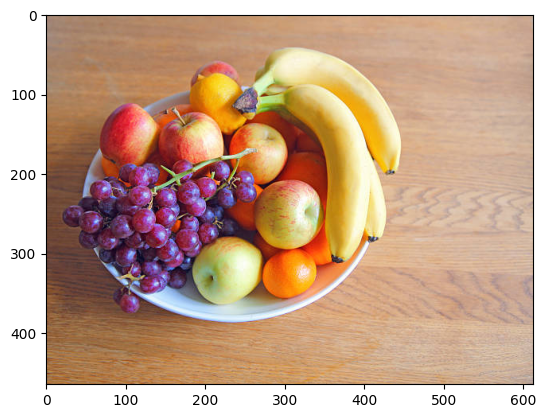

In [2]:

img = cv2.imread('frutas.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imshow('Frutas', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


plt.imshow(img)
# plt.plot()
plt.show()



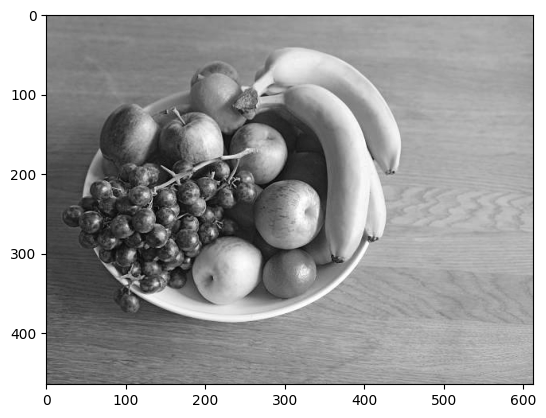

In [3]:
impb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
features = cv2.goodFeaturesToTrack(image=impb, maxCorners=100, 
            qualityLevel=0.01, minDistance = 10, blockSize=3, useHarrisDetector=True, k=0.06)

plt.imshow(impb, cmap='gray')
plt.show()
# cv2.imshow('impb', impb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

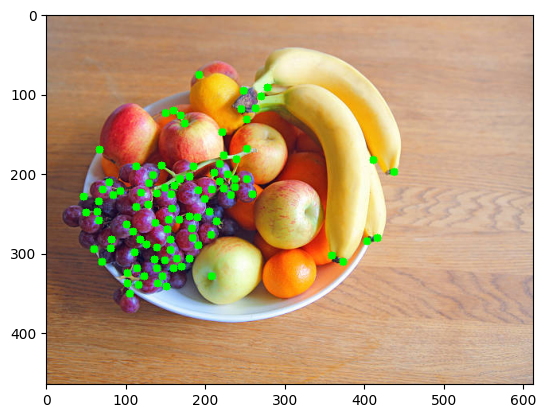

In [4]:
for i in features:
    x,y = i.ravel()
    cv2.circle(img = img,center = (int(x),int(y)),radius = 5,color=(0,255,0),thickness = -1)

plt.imshow(img)
plt.show()

# cv2.imshow('img', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
def HarrisCornerDetector(image, blockSize, ksize, k=0.06):
    #image é uma imagem em tons de cinza
    #blockSize é o tamanho da vizinhança considerada para a detecção de cada canto
    #ksize é o tamanho do filtro de Sobel usado para calcular os gradientes horizontal e vertical
    #k é um parâmetro livre do detector de Harris na equação
    #retorna uma imagem binária com o score de cada pixel
    nlin, ncol = image.shape
    image = np.float32(image)
    image = image/255.0
    Ix = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=ksize)
    Ix2 = Ix*Ix
    Iy2 = Iy*Iy
    Ixy = Ix*Iy
    Rresult = np.zeros((nlin, ncol))
    cont = 0
    for lin in range(blockSize, nlin-blockSize):
        for col in range(blockSize, ncol-blockSize):
            Ix2_block = Ix2[lin-blockSize:lin+blockSize+1, col-blockSize:col+blockSize+1]
            Iy2_block = Iy2[lin-blockSize:lin+blockSize+1, col-blockSize:col+blockSize+1]
            Ixy_block = Ixy[lin-blockSize:lin+blockSize+1, col-blockSize:col+blockSize+1]
            Sxx = np.sum(Ix2_block)
            Syy = np.sum(Iy2_block)
            Sxy = np.sum(Ixy_block)
            det = Sxx*Syy - Sxy**2
            trace = Sxx + Syy
            R = det - k*(trace**2)
            Rresult[lin, col] = R
            if R > 0.01:
                cont += 1
    return Rresult


In [6]:
Rresult = HarrisCornerDetector(impb, 1, 3, 0.05)
RresultCV = cv2.cornerHarris(impb, 1, 3, 0.05)

(Text(0.5, 1.0, 'HarrisCV'), ([], []), ([], []))

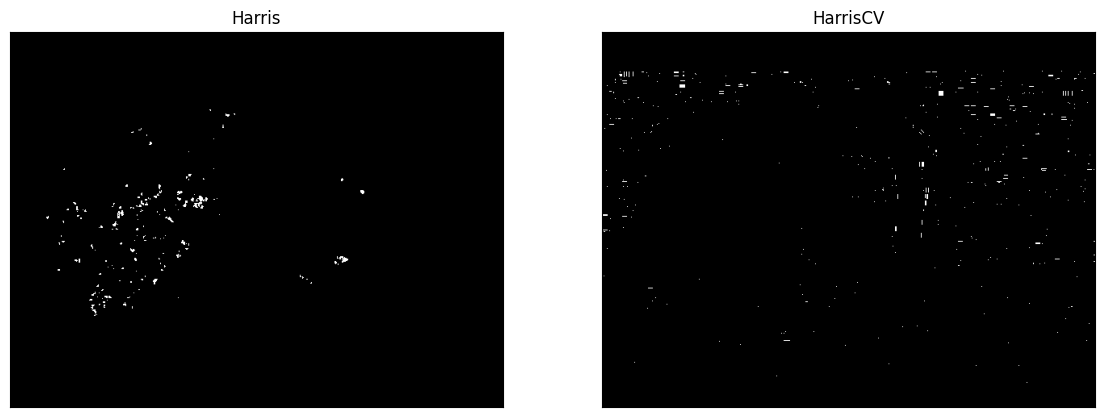

In [7]:
npoints = 1000
PointsInterest = np.zeros(impb.shape)
top_indices = np.argpartition(Rresult.flatten(), -npoints)[-npoints:]
top_row_indices, top_col_indices = np.unravel_index(top_indices, impb.shape)
for i in range(npoints):
    PointsInterest[top_row_indices[i], top_col_indices[i]] = 1

PointsInterestcv = np.zeros(impb.shape)
top_indicescv = np.argpartition(RresultCV.flatten(), -npoints)[-npoints:]
top_row_indicescv, top_col_indicescv = np.unravel_index(top_indicescv, impb.shape)
for i in range(npoints):
    PointsInterestcv[top_row_indicescv[i], top_col_indicescv[i]] = 1

plt.figure(figsize=(14, 5))
plt.subplot(121), plt.imshow(PointsInterest, cmap='gray')
plt.title('Harris'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(PointsInterestcv, cmap='gray')
plt.title('HarrisCV'), plt.xticks([]), plt.yticks([])
    

Definindo a função nonMaximalSupression que tem como objetivo extrair os máximos locais (non maximal supression) usando uma janela 3x3.

In [8]:
def NonMaximalSupression(im, window_size=3, number_max_points=100, min_distance=15):
    nl = im.shape[0]
    nc = im.shape[1]
    maximos = []
    threshold = 0.01*im.max()
    for lin in range(0, nl):
        for col in range(0, nc):
            value = im[lin, col]
            if value > threshold:
                window = im[np.clip(lin-(window_size//2), 0, nl):np.clip(lin+(window_size//2)+1, 0, nl), \
                            np.clip(col-(window_size//2), 0, nc):np.clip(col+(window_size//2)+1, 0, nc)]
                
                if value == np.max(window):
                    maximos.append([lin, col, value])
                
    maximos.sort(key = lambda x: x[2], reverse=True)

    i = 0
    while i < len(maximos):
        j = i+1
        while j < len(maximos):
            norm = np.linalg.norm(np.array(maximos[i][:2])-np.array(maximos[j][:2]))
            if norm < min_distance:
                maximos.pop(j)
            else:
                j += 1
        i += 1

    maximos = maximos[:number_max_points]
    return maximos

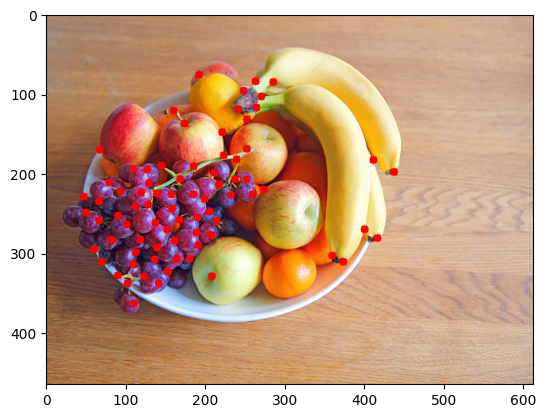

In [9]:
img = cv2.imread('frutas.jpg', cv2.COLOR_BGR2RGB)

features = NonMaximalSupression(Rresult, 3)
for i in features:
    x,y,_ = i
    cv2.circle(img = img,center = (int(y),int(x)),radius = 5,color=(0,0,255),thickness = -1)

plt.imshow(img[...,[2,1,0]])


# 2

In [10]:
img_a = cv2.imread('keble_a.jpg')
img_b = cv2.imread('keble_b.jpg')
img_c = cv2.imread('keble_c.jpg')

gray_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)
gray_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)

Rresult_a = HarrisCornerDetector(gray_a, 1, 3, 0.05)
Rresult_b = HarrisCornerDetector(gray_b, 1, 3, 0.05)
Rresult_c = HarrisCornerDetector(gray_c, 1, 3, 0.05)
print(Rresult_a.shape)

features_a = NonMaximalSupression(Rresult_a, 3)
features_b = NonMaximalSupression(Rresult_b, 3)
features_c = NonMaximalSupression(Rresult_c, 3)

(568, 720)


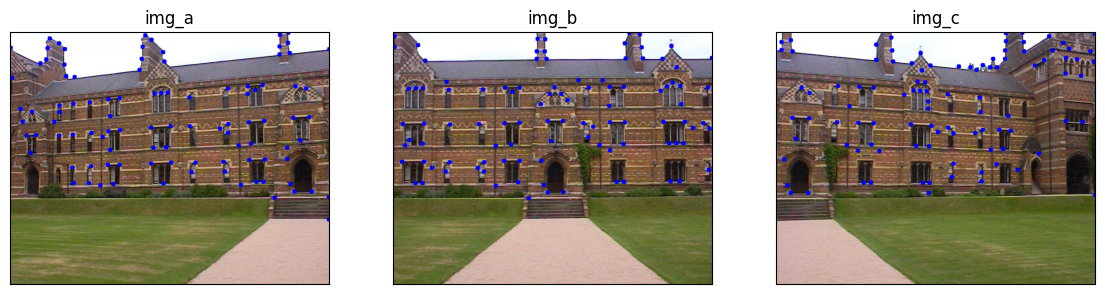

In [11]:
for i in features_a:
    x,y,_ = i
    cv2.circle(img = img_a,center = (int(y),int(x)),radius = 5,color=(255,0,0),thickness = -1)

for i in features_b:
    x,y,_ = i
    cv2.circle(img = img_b,center = (int(y),int(x)),radius = 5,color=(255,0,0),thickness = -1)

for i in features_c:
    x,y,_ = i
    cv2.circle(img = img_c,center = (int(y),int(x)),radius = 5,color=(255,0,0),thickness = -1)

img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 5))
plt.subplot(131), plt.imshow(img_a, cmap='gray')
plt.title('img_a'), plt.xticks([]), plt.yticks([])

img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)
plt.subplot(132), plt.imshow(img_b, cmap='gray')
plt.title('img_b'), plt.xticks([]), plt.yticks([])

img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
plt.subplot(133), plt.imshow(img_c, cmap='gray')
plt.title('img_c'), plt.xticks([]), plt.yticks([])
plt.show()


In [12]:
def find_matches(img_1, max_1, img_2, max_2, patch_size=10):
    correspondences = []
    
    for kp1 in max_1:
        y1, x1, _ = kp1

        # Extract patch from image_1
        patch_1 = img_1[np.clip(y1-(patch_size//2), 0, img_1.shape[0]):np.clip(y1+(patch_size//2)+1, 0, img_1.shape[0]), \
                          np.clip(x1-(patch_size//2), 0, img_1.shape[1]):np.clip(x1+(patch_size//2)+1, 0, img_1.shape[1])]

        optimal_match = None
        minimal_difference = np.inf

        for kp2 in max_2:
            y2, x2, _ = kp2

            # Extract patch from image_2
            patch_2 = img_2[np.clip(y2-(patch_size//2), 0, img_2.shape[0]):np.clip(y2+(patch_size//2)+1, 0, img_2.shape[0]), \
                              np.clip(x2-(patch_size//2), 0, img_2.shape[1]):np.clip(x2+(patch_size//2)+1, 0, img_2.shape[1])]

            try:
                # Compute the sum of squared differences between patches
                ssd = np.sum((patch_1-patch_2)**2)
            except:
                continue

            if ssd < minimal_difference:
                minimal_difference = ssd
                optimal_match = kp2
        
        if optimal_match is not None:
            correspondences.append([kp1[:2], optimal_match[:2]])

    return correspondences

def get_best_matches(image_1, keypoints_1, image_2, keypoints_2, patch_size=9):
    correspondences_1_to_2 = find_matches(image_1, keypoints_1, image_2, keypoints_2, patch_size)
    correspondences_2_to_1 = find_matches(image_2, keypoints_2, image_1, keypoints_1, patch_size)

    mutual_correspondences = []
    for pair_1_to_2 in correspondences_1_to_2:
        for pair_2_to_1 in correspondences_2_to_1:
            if pair_1_to_2[0] == pair_2_to_1[1] and pair_1_to_2[1] == pair_2_to_1[0]:
                mutual_correspondences.append(pair_1_to_2)
                break

    return mutual_correspondences


In [13]:
best_matches = get_best_matches(gray_a, features_a, gray_b, features_b, 20)
best_matches_cb = get_best_matches(gray_c, features_c, gray_b, features_b, 20)

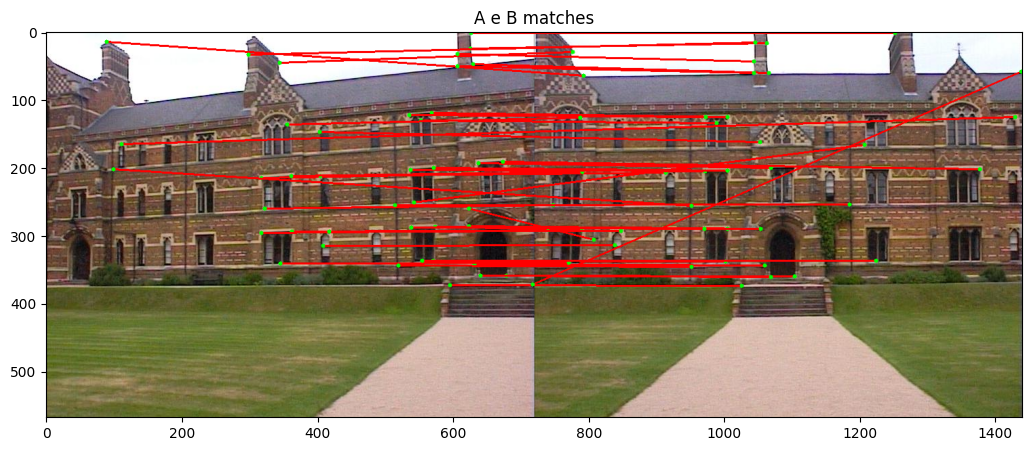

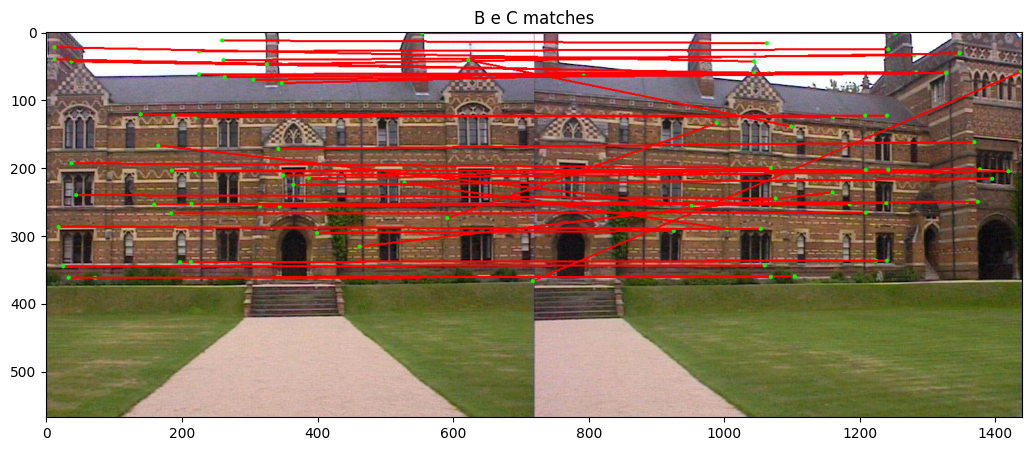

In [14]:
img_a = cv2.imread('keble_a.jpg')
img_b = cv2.imread('keble_b.jpg')
img_c = cv2.imread('keble_c.jpg')
img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)
img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)

def maches(img_a, img_b, best_matches):
    fused = np.hstack((img_a, img_b))

    for match in best_matches:
        a, b = match
        b = (b[0], b[1]+img_a.shape[1])
        cv2.line(fused, (int(a[1]), int(a[0])), (int(b[1]), int(b[0])), (255, 0, 0), 2)
        cv2.circle(fused, (int(a[1]), int(a[0])), 3, (0, 255, 0), -1)
        cv2.circle(fused, (int(b[1]), int(b[0])), 3, (0, 255, 0), -1)
    return fused

matches_AB = maches(img_a, img_b, best_matches)
matches_BC = maches(img_b, img_c, best_matches_cb)


plt.figure(figsize=(14, 5))
plt.imshow(matches_AB)
plt.title('A e B matches')
plt.show()

plt.figure(figsize=(14, 5))
plt.imshow(matches_BC)
plt.title('B e C matches')
plt.show()


# 3

In [15]:
def find_homography(source_points, destination_points):
    h = []
    for source, destination in zip(source_points, destination_points):
        x, y = source
        u, v = destination
        h.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        h.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    
    h = np.array(h)
    _, _, V = np.linalg.svd(h)
    H = V[-1].reshape((3, 3))
    
    return H


def my_projection(img, projection_matrix, centro):
    height, width = img.shape[:2]
    projected_image = np.zeros((height,width,3), np.uint8)

    matriz_translacao = [ [1, 0, centro[0]], [0, 1, centro[1]], [0, 0, 1] ]

    matriz_composicao = np.matmul(np.matmul(matriz_translacao, projection_matrix), np.linalg.inv(matriz_translacao))

    m_comp_inv = np.linalg.inv(matriz_composicao)
    for linr in range(height):
        for colr in range(width):
            pos_rot = np.matrix([linr, colr, 1]).T

            pos_orig = np.matmul(m_comp_inv, pos_rot)
            
            c = pos_orig[2,0]
            pos_orig = pos_orig / c

            lin = round(pos_orig[0,0])
            col = round(pos_orig[1,0])

            if (lin >=0 and lin < height) and (col >= 0 and col < width):
                projected_image[linr, colr] = img[lin, col]
                
    return projected_image


In [16]:
import numpy as np
import cv2

def ransac(src, dest, iter=1000, threshold=5):
    """
    Perform the RANSAC algorithm to find the best homography matrix.

    Parameters:
    src (np.array): Source points.
    dest (np.array): Destination points.
    iter (int): Number of iterations to run the algorithm.
    threshold (float): Distance threshold to determine inliers.

    Returns:
    np.array: The best homography matrix found.
    """
    max_inliers = []
    best_H = None
    
    for _ in range(iter):
        # Randomly select 4 points from the source points
        indices = np.random.choice(len(src), 4, replace=False)
        source_subset = src[indices].astype(np.float32)
        destination_subset = dest[indices].astype(np.float32)
        
        # Compute the homography matrix using the selected points
        H = cv2.getPerspectiveTransform(source_subset, destination_subset)
        
        inliers = []
        
        for source_point, destination_point in zip(src, dest):
            projected_point = np.dot(H, np.array([source_point[0], source_point[1], 1]))
            projected_point /= projected_point[2]  # Normalize the projected point
            
            distance = np.linalg.norm(destination_point - projected_point[:2])
            
            if distance < threshold:
                inliers.append((source_point, destination_point))

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_H = cv2.findHomography(
                np.array([p[0] for p in inliers]), 
                np.array([p[1] for p in inliers]), 
                method=0
            )[0]

    return best_H


[[ 1.15915184e+00  1.21841382e-01 -6.03023775e+01]
 [-2.89255807e-02  1.22998189e+00 -3.59571593e+02]
 [-2.50969373e-06  3.17735441e-04  1.00000000e+00]]


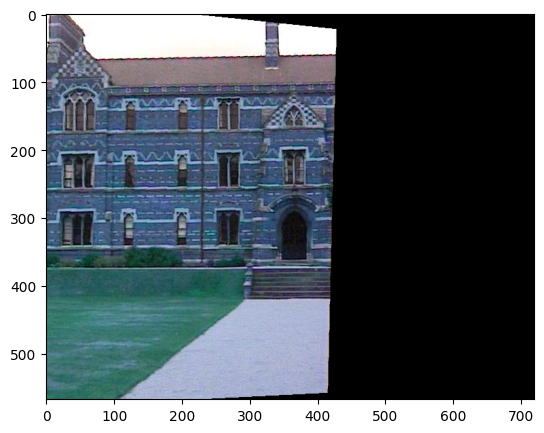

In [17]:
source_points = np.array([p[0] for p in best_matches])
destination_points = np.array([p[1] for p in best_matches])

H_AB = ransac(source_points, destination_points)
# H_AB /= H_AB[2, 2]
print(H_AB)
projection_ab = my_projection(img_a, H_AB, (0,0))

projection_ab = cv2.cvtColor(projection_ab, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 5))
plt.imshow(projection_ab, cmap='gray')
plt.show()

# 4

([], [])

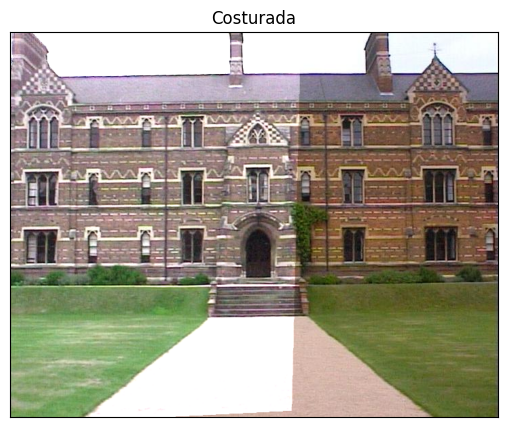

In [18]:
stitched = cv2.addWeighted(projection_ab, 0.5, img_b, 1, 0.0)

# Exibe a imagem
plt.figure(figsize=(14, 5))                                                               
plt.imshow(stitched, cmap='gray')
plt.title('Costurada'), plt.xticks([]), plt.yticks([])
plt.xticks([])

[[ 1.21245288e+00  1.47056314e-01 -7.38634900e+01]
 [-2.74109233e-02  1.29357861e+00 -4.02584800e+02]
 [ 1.82138571e-05  3.99742849e-04  1.00000000e+00]]


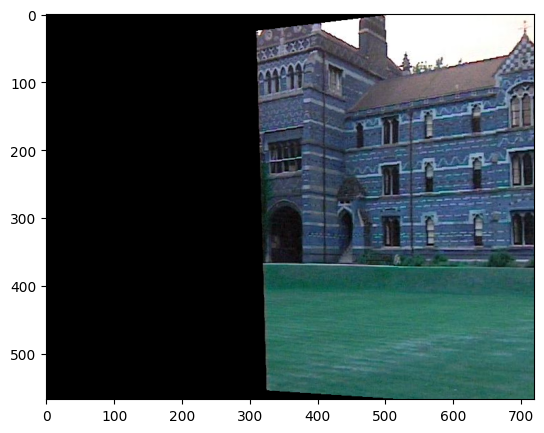

In [19]:
img_c = cv2.imread("keble_c.jpg")[..., ::-1]
source_points_bc = np.array([p[0] for p in best_matches_cb])
destination_points_bc = np.array([p[1] for p in best_matches_cb])

H_BC = ransac(destination_points_bc, source_points_bc)
# H_BC /= H_BC[2, 2]
print(H_BC)

projection_bc = my_projection(img_c, H_BC, (0,0))

projection_bc = cv2.cvtColor(projection_bc, cv2.COLOR_BGR2RGB)
image2_bc = cv2.cvtColor(projection_bc, cv2.COLOR_BGR2RGB)

# # Exibe a imagem
# plt.figure(figsize=(14, 5))
# plt.imshow(projection_bc, cmap='gray')
# plt.show()

# flip horizontal
projection_bc = cv2.flip(projection_bc, 1)
plt.figure(figsize=(14, 5))
plt.imshow(projection_bc, cmap='gray')
plt.show()


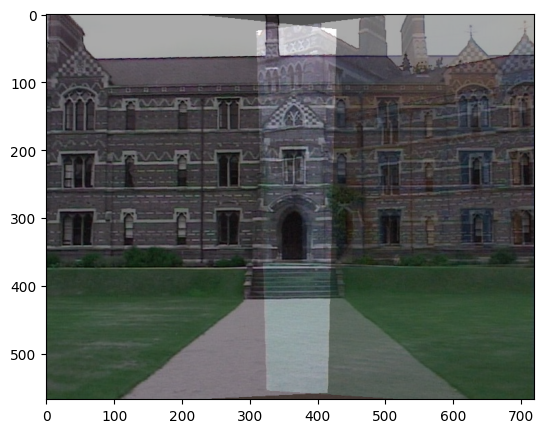

In [20]:
# join the three images using weighted sum

join = np.zeros_like(projection_ab, dtype=np.float32)

for img in [projection_ab, img_b, projection_bc]:
    join += img

join = join / join.max()

plt.figure(figsize=(10, 5))
plt.imshow(join)

# Extra

In [21]:
# # Utilizando as fun ̧c ̃oes criadas nesta lista, fa ̧ca uma fun ̧c ̃ao find wally que
# # receba duas imagens, uma referente a uma imagem do livro Onde est ́a Wally
# # (cenario.png), e a segunda imagem referente ao pr ́oprio Wally (wally.png). Sua
# # fun ̧c ̃ao deve retornar a imagem do cen ́ario com a imagem do Wally destacada
# # (basta mudar as cores de wally.png e aplicar uma transforma ̧c ̃ao H que leva a
# # imagem em cenario wally).
# # Perceba que a imagem dada de Wally  ́e exatamente a imagem da pr ́opria
# # figura, por ́em rotacionada. comente se o m ́etodo funcionaria para uma imagem
# # qualquer de Wally, isto  ́e, quais as limita ̧c ̃oes dessa implementa ̧c ̃ao?
# # Caso queira ler mais sobre Wally, segue um link do Ranson Olson que fez
# # uma estrat ́egia de busca  ́otima do Wally:
# # https://randalolson.com/2015/02/03/heres-waldo-computing-the-optimal-search-
# # strategy-for-finding-waldo/
# # 2

In [22]:
# import cv2
# import numpy as np
# import random
# from skimage.metrics import structural_similarity as ssim

# def initialize_population(pop_size, upper_right_corner, crop_size):
#     height, width = upper_right_corner.shape[:2]
#     population = []
#     for _ in range(pop_size):
#         x = random.randint(0, width - crop_size[1])
#         y = random.randint(0, height - crop_size[0])
#         population.append((x, y))
#     return population

# def evaluate_fitness(scene_img, wally_img, individual, crop_size):
#     x, y = individual
#     cropped_scene = scene_img[y:y + crop_size[0], x:x + crop_size[1]]
#     cropped_scene_gray = cv2.cvtColor(cropped_scene, cv2.COLOR_BGR2GRAY)
#     wally_gray = cv2.cvtColor(wally_img, cv2.COLOR_BGR2GRAY)
#     score, _ = ssim(cropped_scene_gray, wally_gray, full=True)
#     return score

# def select_best(population, fitnesses, num_best):
#     sorted_population = [ind for ind, fit in sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)]
#     return sorted_population[:num_best]

# def crossover(parent1, parent2):
#     x1, y1 = parent1
#     x2, y2 = parent2
#     return (x1, y2) if random.random() > 0.5 else (x2, y1)

# def mutate(individual, height, width, crop_size, mutation_rate=0.1):
#     if random.random() < mutation_rate:
#         x, y = individual
#         x = min(max(0, x + int(np.random.normal(0, crop_size[1] // 10))), width - crop_size[1])
#         y = min(max(0, y + int(np.random.normal(0, crop_size[0] // 10))), height - crop_size[0])
#         return (x, y)
#     return individual

# def genetic_algorithm(scene_img, wally_img, pop_size=100, num_generations=50, num_best=20, mutation_rate=0.1):
#     height, width = scene_img.shape[:2]
#     crop_size = wally_img.shape[:2]
#     upper_right_corner = scene_img[0:height//2, width//2:width]
    
#     population = initialize_population(pop_size, upper_right_corner, crop_size)

#     for generation in range(num_generations):
#         fitnesses = [evaluate_fitness(upper_right_corner, wally_img, ind, crop_size) for ind in population]
#         best_individuals = select_best(population, fitnesses, num_best)
        
#         new_population = []
#         while len(new_population) < pop_size:
#             parent1 = random.choice(best_individuals)
#             parent2 = random.choice(best_individuals)
#             child = crossover(parent1, parent2)
#             child = mutate(child, height//2, width//2, crop_size, mutation_rate)
#             new_population.append(child)
        
#         population = new_population
        
#         if max(fitnesses) > 0.95:
#             break

#     best_match = max(zip(population, fitnesses), key=lambda x: x[1])[0]
#     x, y = best_match
#     x += width // 2
#     scene_img_with_box = cv2.rectangle(scene_img.copy(), (x, y), (x + crop_size[1], y + crop_size[0]), (0, 255, 0), 3)

#     # Display the result
#     cv2.imshow("Wally Found", scene_img_with_box)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

#     return scene_img_with_box

# # Example usage
# scene_img_path = 'cenario.png'
# wally_img_path = 'wally.png'
# scene_img = cv2.imread(scene_img_path)
# wally_img = cv2.imread(wally_img_path)
# genetic_algorithm(scene_img, wally_img)
